In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Cargamos la data
file_path = 'Telco-Customer-Churn.xlsx'
data = pd.read_excel(file_path)



In [ ]:
# Pregunta 1:
# Análisis exploratorio inicial
print(data.head())  # Muestra las primeras filas



   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract Pape

In [ ]:
# Lista de columnas con valores "Yes" / "No" que necesitan ser convertidas a 1/0
binary_columns = ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']

# Convertir "Yes"/"No" a 1/0 para cada columna en la lista
for column in binary_columns:
    data[column] = data[column].map({'Yes': 1, 'No': 0})

# Para las variables con tres categorías como 'MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
# 'TechSupport', 'StreamingTV', 'StreamingMovies', aplicar un mapeo similar considerando 'No internet service' como 'No'
ternary_columns = ['MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

# Convertir "Yes"/"No"/"No phone service" o "No internet service" a 1/0, considerando ambas formas de "No" como 0
ternary_conversion_map = {'Yes': 1, 'No': 0, 'No phone service': 0, 'No internet service': 0}
for column in ternary_columns:
    data[column] = data[column].map(ternary_conversion_map)


In [ ]:
# Valores Faltantes, Anomalias, duplicados.
quality_report = {
    "missing_values": data.isnull().sum(),
    "data_types": data.dtypes,
    "duplicate_rows": data.duplicated().sum(),
    "summary_statistics": data.describe()
}

quality_report

{'missing_values': customerID           0
 gender               0
 SeniorCitizen        0
 Partner              0
 Dependents           0
 tenure               0
 PhoneService         0
 MultipleLines        0
 InternetService      0
 OnlineSecurity       0
 OnlineBackup         0
 DeviceProtection     0
 TechSupport          0
 StreamingTV          0
 StreamingMovies      0
 Contract             0
 PaperlessBilling     0
 PaymentMethod        0
 MonthlyCharges       0
 TotalCharges        11
 Churn                0
 dtype: int64,
 'data_types': customerID           object
 gender               object
 SeniorCitizen         int64
 Partner               int64
 Dependents            int64
 tenure                int64
 PhoneService          int64
 MultipleLines         int64
 InternetService      object
 OnlineSecurity        int64
 OnlineBackup          int64
 DeviceProtection      int64
 TechSupport           int64
 StreamingTV           int64
 StreamingMovies       int64
 Contract     

In [ ]:
# Pregunta 2:
# Manejo de valores faltantes en TotalCharges. Los reemplazamos con la media de la columna.
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce') # Convertir a numérico, fuerza NaN en errores
# Imputación de valores faltantes en 'TotalCharges' con la mediana (menos sensible a outliers que la media)
churn_data = data
churn_data['TotalCharges'].fillna(churn_data['TotalCharges'].median(), inplace=True)

# Confirmar que no hay más valores faltantes en 'TotalCharges'
missing_values_updated = churn_data.isnull().sum()

missing_values_updated['TotalCharges']



0

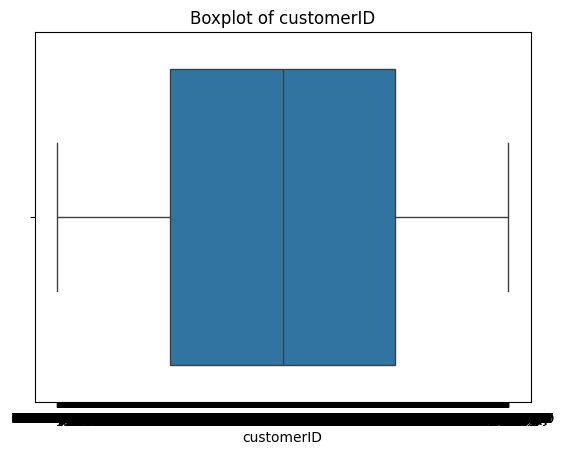

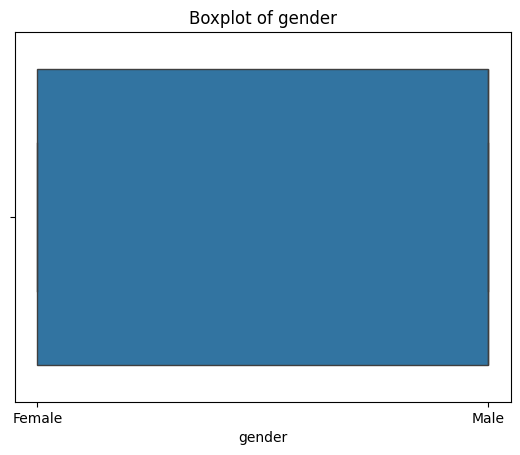

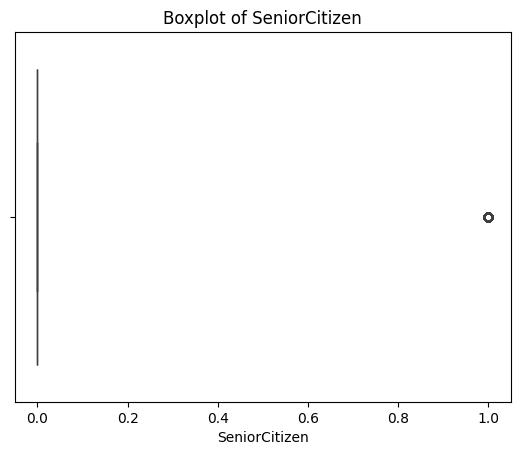

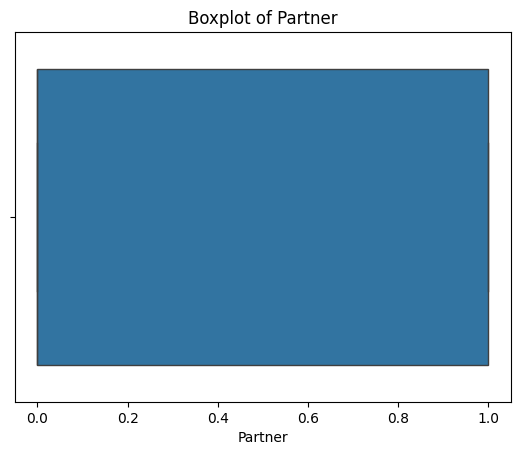

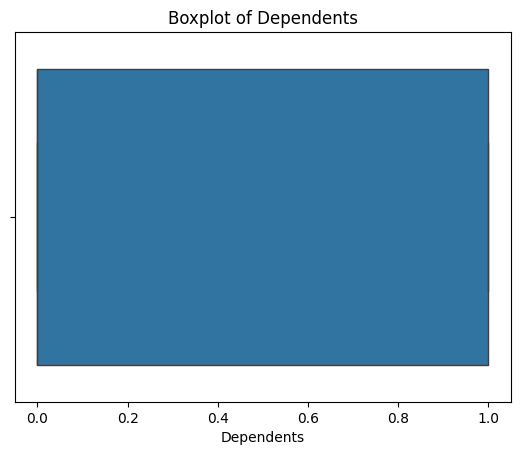

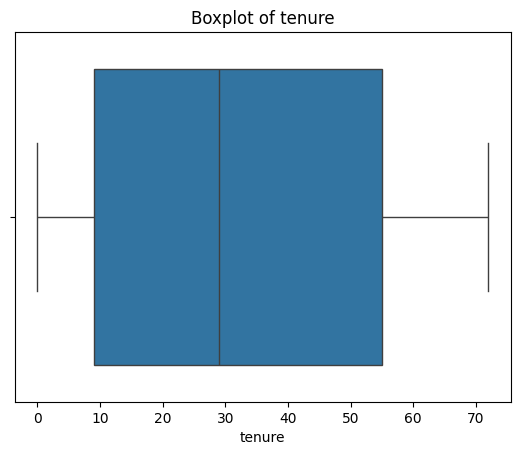

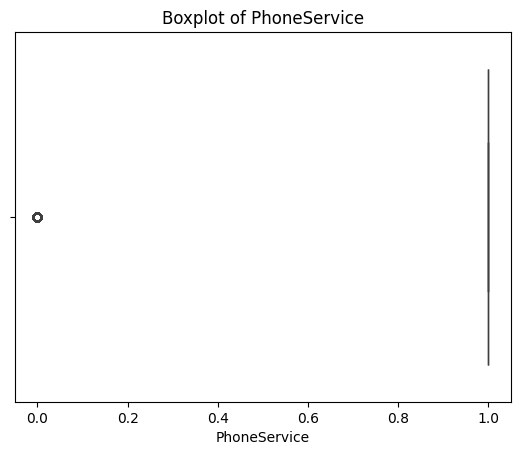

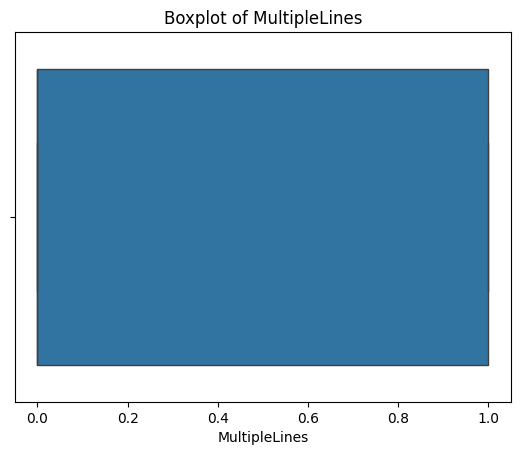

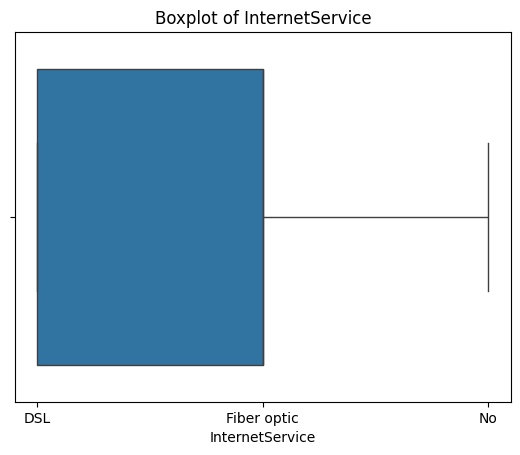

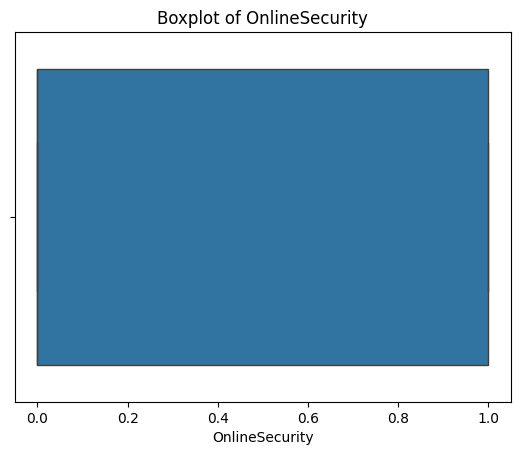

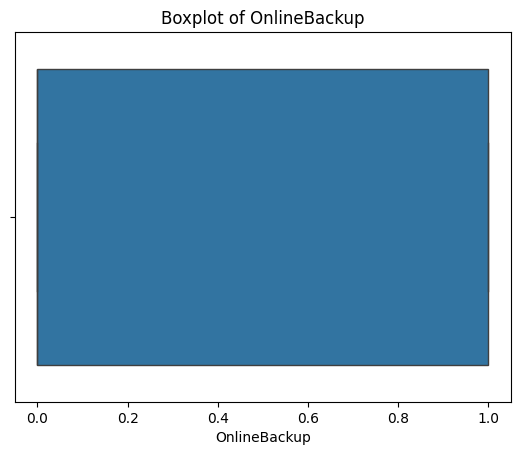

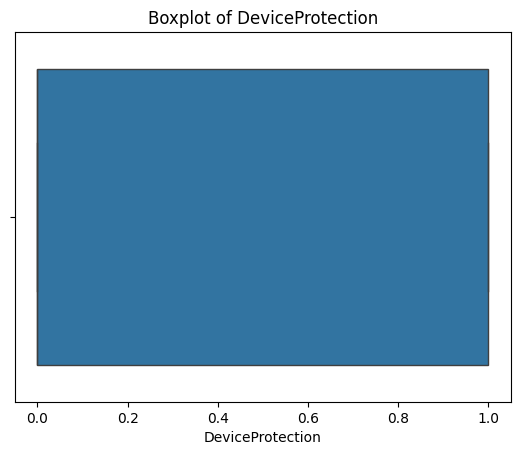

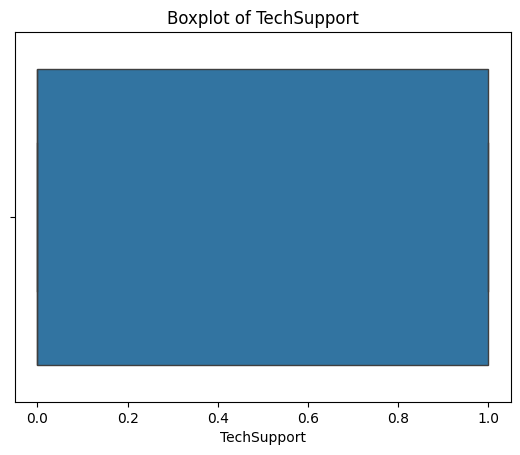

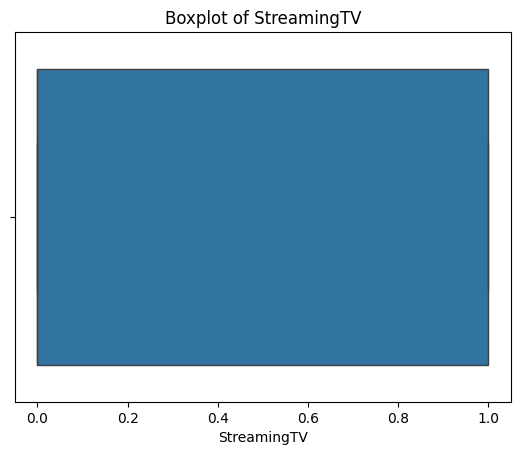

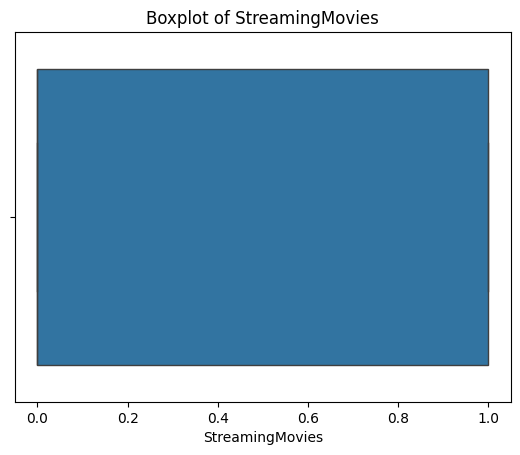

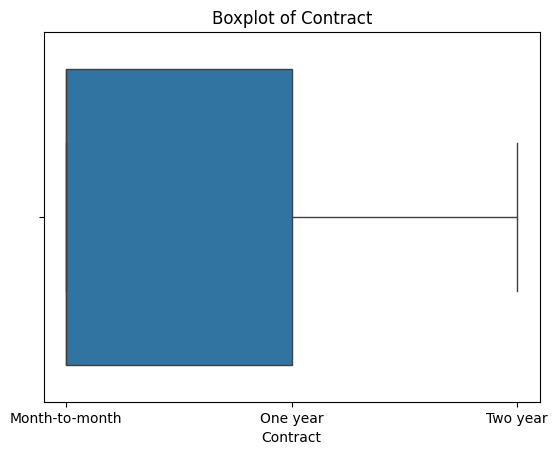

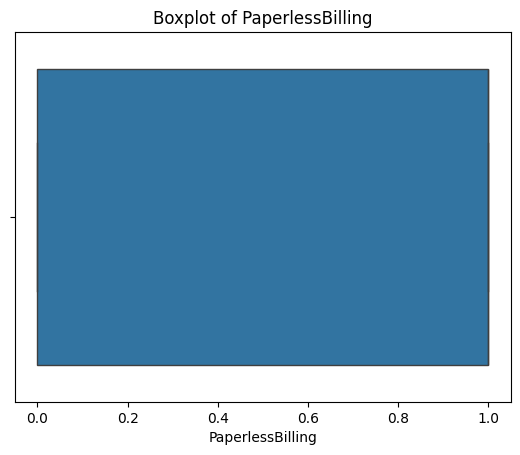

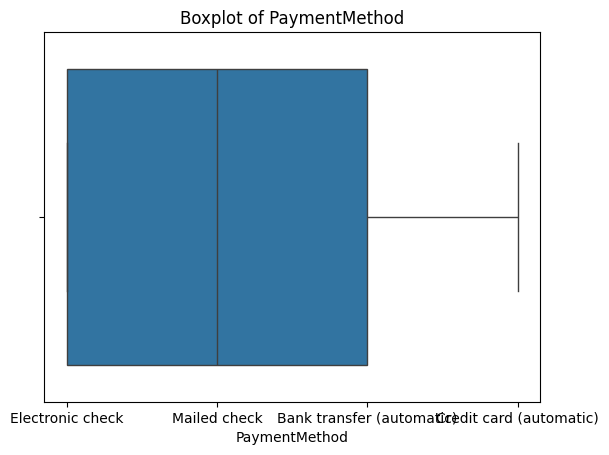

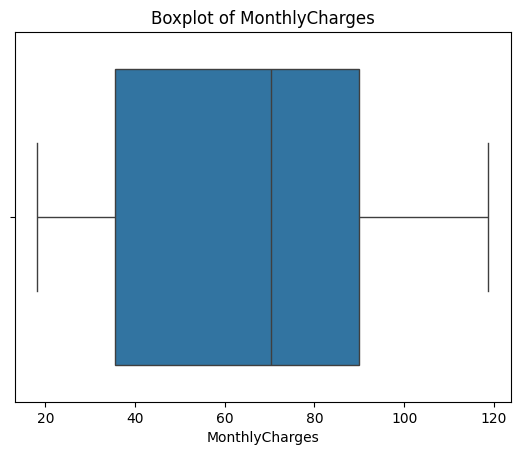

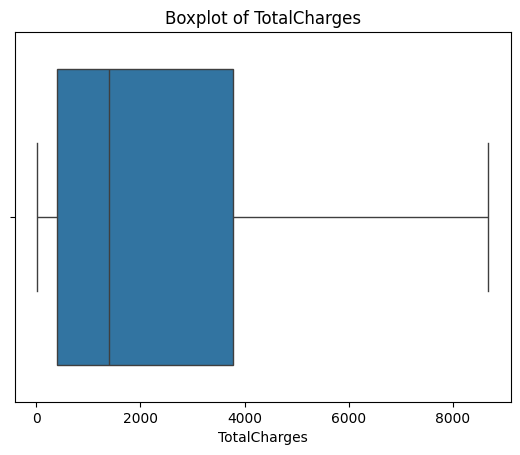

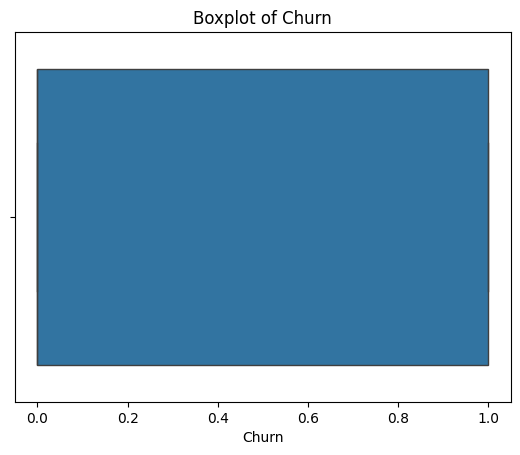

In [ ]:
# prompt: genera un grafico boxplot para cada variable

import matplotlib.pyplot as plt
import seaborn as sns

# Generar un boxplot para cada variable
for column in churn_data.columns:
    sns.boxplot(x=churn_data[column])
    plt.title(f'Boxplot of {column}')
    plt.show()


No se visualiza presencia de atipicos por lo que no sera necesario realizar limpieza de estos en este caso

In [ ]:
churn_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   int64  
 4   Dependents        7043 non-null   int64  
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   int64  
 7   MultipleLines     7043 non-null   int64  
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   int64  
 10  OnlineBackup      7043 non-null   int64  
 11  DeviceProtection  7043 non-null   int64  
 12  TechSupport       7043 non-null   int64  
 13  StreamingTV       7043 non-null   int64  
 14  StreamingMovies   7043 non-null   int64  
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   int64  


In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split

# Identificar variables numéricas y categóricas
numeric_features = ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']
categorical_features = churn_data.select_dtypes(include=['object']).columns.tolist()

# Excluir 'customerID' si no se usa en el modelado
categorical_features.remove('customerID')

# Crear transformadores para el preprocesamiento
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

# Dividir el conjunto de datos en características (X) y objetivo (y)
X = churn_data.drop(['Churn', 'customerID'], axis=1)  # Excluir 'customerID'
y = churn_data['Churn']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear el pipeline para KNN
pipeline_knn = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', KNeighborsClassifier())])
pipeline_knn.fit(X_train, y_train)

# Crear el pipeline para Árbol de Decisión
pipeline_dt = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', DecisionTreeClassifier(random_state=42))])
pipeline_dt.fit(X_train, y_train)

# Crear un preprocesador separado para Naive Bayes que solo procesa características numéricas
preprocessor_nb = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features)
    ])

# Crear el pipeline para Naive Bayes
pipeline_nb = Pipeline(steps=[('preprocessor', preprocessor_nb),
                              ('classifier', GaussianNB())])
pipeline_nb.fit(X_train, y_train)

# Los modelos están entrenados y listos para ser evaluados


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['SeniorCitizen', 'tenure',
                                                   'MonthlyCharges',
                                                   'TotalCharges'])])),
                ('classifier', GaussianNB())])

In [ ]:
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_validate
from sklearn.metrics import classification_report

# Optimización de hiperparámetros para KNN
param_grid_knn = {'classifier__n_neighbors': [3, 5, 7],
                  'classifier__weights': ['uniform', 'distance']}
grid_search_knn = GridSearchCV(pipeline_knn, param_grid=param_grid_knn, cv=5, scoring='accuracy')
grid_search_knn.fit(X_train, y_train)

# Optimización de hiperparámetros para Árbol de Decisión
param_grid_dt = {'classifier__max_depth': [None, 10, 20, 30],
                 'classifier__min_samples_split': [2, 10, 20]}
grid_search_dt = GridSearchCV(pipeline_dt, param_grid=param_grid_dt, cv=5, scoring='accuracy')
grid_search_dt.fit(X_train, y_train)

# Para GaussianNB generalmente hay menos hiperparámetros para ajustar, pero podrías ajustar 'var_smoothing'
param_grid_nb = {'classifier__var_smoothing': [1e-9, 1e-8, 1e-7]}
grid_search_nb = GridSearchCV(pipeline_nb, param_grid=param_grid_nb, cv=5, scoring='accuracy')
grid_search_nb.fit(X_train, y_train)

# Evaluar el rendimiento de los modelos con los hiperparámetros optimizados
# Usando cross_validate para obtener varias métricas a la vez
scoring_metrics = ['accuracy', 'recall', 'precision', 'f1']
cv_results_knn = cross_validate(grid_search_knn.best_estimator_, X_train, y_train, cv=5, scoring=scoring_metrics)
cv_results_dt = cross_validate(grid_search_dt.best_estimator_, X_train, y_train, cv=5, scoring=scoring_metrics)
cv_results_nb = cross_validate(grid_search_nb.best_estimator_, X_train, y_train, cv=5, scoring=scoring_metrics)

# Calculando el promedio de las métricas
average_scores_knn = {metric: scores.mean() for metric, scores in cv_results_knn.items()}
average_scores_dt = {metric: scores.mean() for metric, scores in cv_results_dt.items()}
average_scores_nb = {metric: scores.mean() for metric, scores in cv_results_nb.items()}

# Imprimir los resultados
print("KNN Average Scores:", average_scores_knn)
print("Decision Tree Average Scores:", average_scores_dt)
print("Naive Bayes Average Scores:", average_scores_nb)

# También podrías querer obtener un informe de clasificación en el conjunto de prueba
y_pred_knn = grid_search_knn.predict(X_test)
y_pred_dt = grid_search_dt.predict(X_test)
y_pred_nb = grid_search_nb.predict(X_test)

print("Classification Report for KNN:")
print(classification_report(y_test, y_pred_knn))

print("Classification Report for Decision Tree:")
print(classification_report(y_test, y_pred_dt))

print("Classification Report for Naive Bayes:")
print(classification_report(y_test, y_pred_nb))


KNN Average Scores: {'fit_time': 0.025388145446777345, 'score_time': 0.2539807319641113, 'test_accuracy': 0.7710318817464433, 'test_recall': 0.4879554069119287, 'test_precision': 0.5820147749823955, 'test_f1': 0.5308344379717271}
Decision Tree Average Scores: {'fit_time': 0.04483795166015625, 'score_time': 0.02260165214538574, 'test_accuracy': 0.7653523004691876, 'test_recall': 0.49667781493868457, 'test_precision': 0.567122156542661, 'test_f1': 0.5269371211614731}
Naive Bayes Average Scores: {'fit_time': 0.013464403152465821, 'score_time': 0.017002010345458986, 'test_accuracy': 0.7708537890405217, 'test_recall': 0.4926086956521739, 'test_precision': 0.5812452864319296, 'test_f1': 0.5325592297376505}
Classification Report for KNN:
              precision    recall  f1-score   support

           0       0.84      0.87      0.86      1036
           1       0.61      0.55      0.58       373

    accuracy                           0.79      1409
   macro avg       0.73      0.71      0.

Para el  modelo KNN:

Precisión (Accuracy): La precisión general del modelo en el conjunto de prueba es del 73%, lo que significa que el 73% de las predicciones del modelo son correctas.

Precision: La precisión para la clase 0 es del 84% y para la clase 1 es del 61%. La precisión se refiere a la proporción de identificaciones positivas que fueron realmente correctas. Para la clase 0 (no churn), el modelo es bastante bueno identificando correctamente a los clientes que no se van, pero no tan bueno para la clase 1 (churn).

Recall (Sensibilidad): El recall para la clase 0 es del 87% y para la clase 1 es del 55%. El recall se refiere a la proporción de positivos reales que fueron identificados correctamente. Esto significa que el modelo es capaz de identificar el 87% de los clientes que realmente no se van (clase 0), pero solo el 55% de los clientes que sí se van (clase 1).

F1-Score: El F1-score para la clase 0 es del 86% y para la clase 1 es del 58%. El F1-score es la media armónica de la precisión y el recall, proporcionando un balance entre ambas métricas. Un F1-score alto indica un buen equilibrio entre precisión y recall. Para la clase 0, el modelo tiene un F1-score alto, pero para la clase 1, el F1-score es considerablemente más bajo, lo que indica que el modelo no es tan efectivo para predecir el churn.

Support: El support es el número de ocurrencias reales de la clase en el conjunto de datos. Para la clase 0, hay 1036 casos, y para la clase 1, hay 373 casos. Esto indica que el conjunto de datos está desequilibrado, con más casos de no churn que de churn.

Podriamos seguir explicando modelo por modelo pero es evidente que los 3 modelos son similares, sin embargo se puede apreciar que knn y naive bayes similares macro avg, por lo que en este caso eligiria el modelo mas simple o que menos tiempo lleva realizar, Naive Bayes es mas simple por lo que es el modelo que utilizaria en este caso.